# Notebook 7 - Property modeling with mol2vec

By Vincent Blay, Tijana Radivojevic November 2021 - May 2022

This notebook was developed using **RPReactor 3.8** kernel on [jprime.lbl.gov](https://gpu2.ese.lbl.gov/).

In this notebook, we explore the application of [mol2vec embeddings](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00616) to model different molecular properties. The embeddings are used as a drop-in replacement of conventional molecular descriptors. Given the relatively high dimensionality of mol2vec embeddings (300-D), we apply the heuristic feature selection approach that was also used in notebooks 5 and 6.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

%run "./plotting.py"

In [2]:
%config InlineBackend.figure_format = 'retina'

We already have the molecules embedded using mol2vec:

In [3]:
df_mol2vec = pd.read_csv('./data/mol2vec_all.csv', index_col=0)
df_mol2vec.head()

,Smiles,dataset,mol2vec-000,mol2vec-001,mol2vec-002,mol2vec-003,mol2vec-004,mol2vec-005,mol2vec-006,mol2vec-007,...,mol2vec-290,mol2vec-291,mol2vec-292,mol2vec-293,mol2vec-294,mol2vec-295,mol2vec-296,mol2vec-297,mol2vec-298,mol2vec-299
0,C/C=C/C(C)(C)C,RON,-0.892758,2.260725,-0.885212,0.085897,2.098727,-1.027072,-4.708672,-0.178004,...,-2.932562,-0.508684,3.100115,-0.821230,-2.645380,-3.025425,-0.382884,-1.689788,-5.125613,-1.924297
1,C/C=C/CCC(C)C,RON,-0.678342,-0.238011,-1.003397,0.774230,2.981085,-0.551984,-5.090776,-0.281822,...,-1.851958,1.159234,2.734748,0.194709,-3.712619,-0.925730,-0.716665,-2.982629,-4.313823,-1.696794
2,O=C1CCCC1,RON,1.234810,-1.350805,-1.046149,1.105939,-0.766294,-0.839044,-1.632772,1.366373,...,0.061407,4.001074,-0.895604,-0.483040,-3.224171,-1.588557,-2.406893,-1.329926,-2.014662,0.257858
3,C1CCCC1,RON,1.247706,-1.549743,0.130658,1.204699,-0.932407,-0.460625,-1.557672,0.880275,...,0.405841,3.888128,-0.772358,-1.161128,-2.507605,-1.529295,-1.959982,-1.544674,-1.787258,-0.313531
4,C1CCCCC1,RON,1.497248,-1.859691,0.156789,1.445638,-1.118889,-0.552750,-1.869206,1.056330,...,0.487009,4.665753,-0.926829,-1.393353,-3.009126,-1.835154,-2.351978,-1.853608,-2.144710,-0.376238


## Research Octane Number (RON)

Let us load the data and look at the distribution:

In [5]:
df = pd.read_csv("./data/data_RON.csv")
smiles = df.Smiles
Y = df.RON
print(len(smiles))

194


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


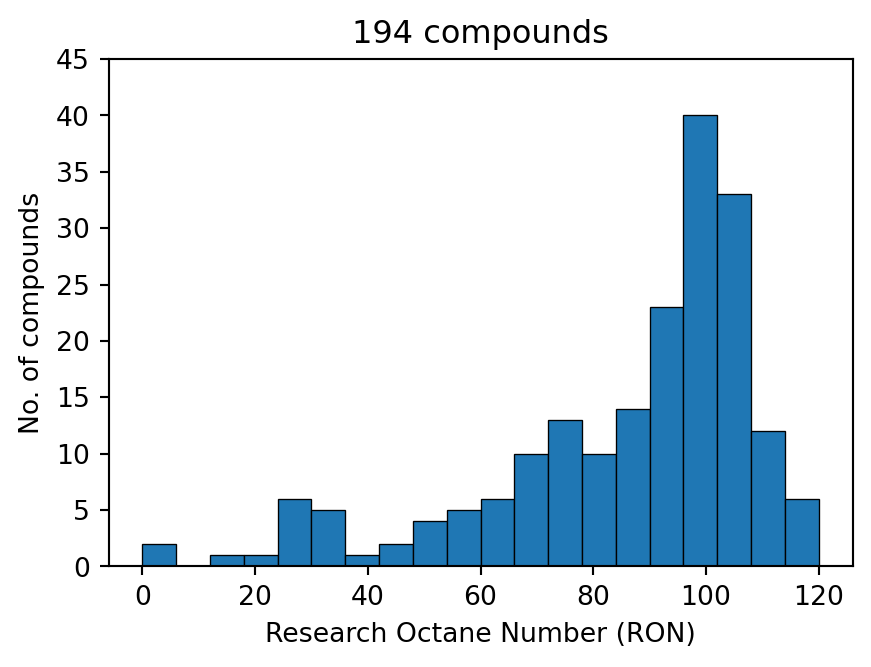

In [6]:
plot_histogram(Y, xlabel="Research Octane Number (RON)")

In [7]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='RON'].iloc[:,2:])
D.shape

(194, 300)

Define the partitions for cross-validation.

In [4]:
num_of_partitions = 10
kf = KFold(n_splits=num_of_partitions, shuffle=True, random_state=42)

We want to select a subset of descriptors that we will use to train the model.

In [5]:
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=15)


Define hyperparameters for the regression model:

In [6]:
param_grid = {
    'C': [1, 5, 7, 10, 30, 50, 100, 300, 500], 
    'epsilon': [0.1, 0.3, 1, 3, 5, 10, 20],
    'kernel': ['rbf']
}

Perform cross-validation:

In [11]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 300, 'epsilon': 3, 'kernel': 'rbf'}
Partition 2/10
{'C': 500, 'epsilon': 5, 'kernel': 'rbf'}
Partition 3/10
{'C': 100, 'epsilon': 5, 'kernel': 'rbf'}
Partition 4/10
{'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 5/10
{'C': 50, 'epsilon': 3, 'kernel': 'rbf'}
Partition 6/10
{'C': 300, 'epsilon': 1, 'kernel': 'rbf'}
Partition 7/10
{'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 8/10
{'C': 100, 'epsilon': 1, 'kernel': 'rbf'}
Partition 9/10
{'C': 50, 'epsilon': 3, 'kernel': 'rbf'}
Partition 10/10
{'C': 100, 'epsilon': 3, 'kernel': 'rbf'}
CPU times: user 3min 46s, sys: 241 ms, total: 3min 47s
Wall time: 3min 47s


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


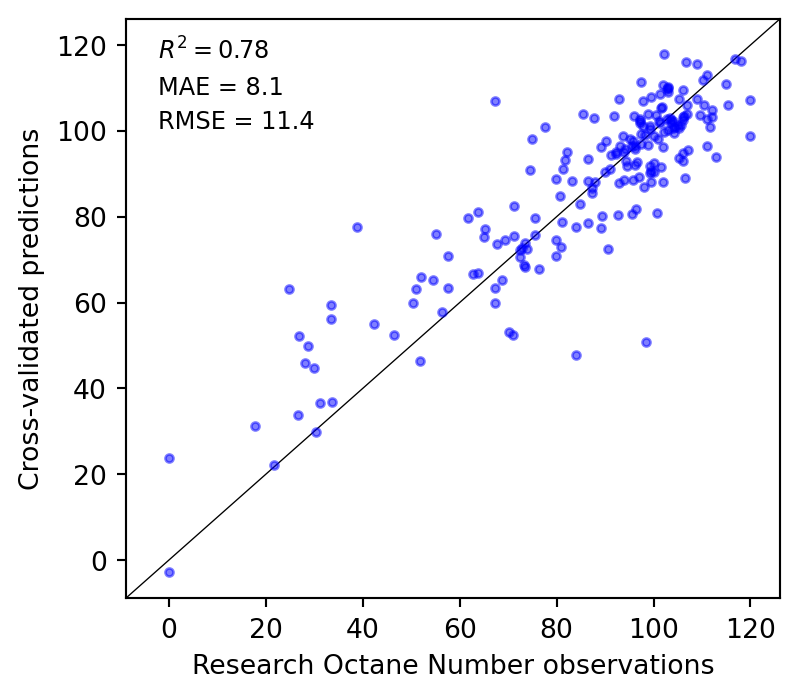

In [12]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Research Octane Number observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/mol2vec/RON_mol2vec.svg') 

## Cetane Number (CN)

In [13]:
df = pd.read_csv("./data/data_CN.csv")
smiles = df.Smiles
Y = df.CN
print(len(smiles))

545


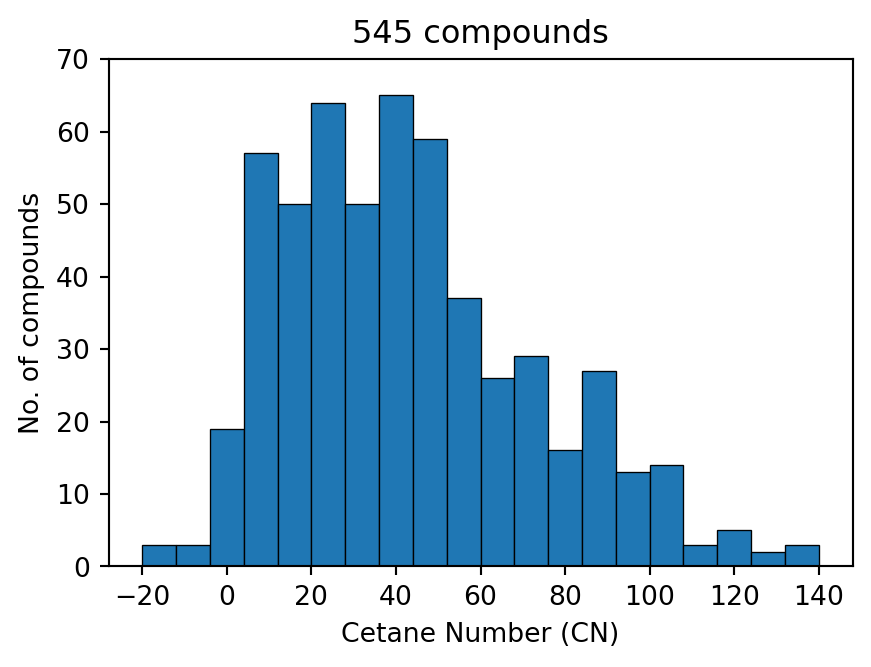

In [14]:
plot_histogram(Y, xlabel="Cetane Number (CN)")

In [15]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='CN'].iloc[:,2:])
D.shape

(545, 300)

In [16]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 2/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 3/10
{'C': 50, 'epsilon': 10, 'kernel': 'rbf'}
Partition 4/10
{'C': 100, 'epsilon': 5, 'kernel': 'rbf'}
Partition 5/10
{'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 6/10
{'C': 500, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 7/10
{'C': 500, 'epsilon': 10, 'kernel': 'rbf'}
Partition 8/10
{'C': 100, 'epsilon': 5, 'kernel': 'rbf'}
Partition 9/10
{'C': 300, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 10/10
{'C': 100, 'epsilon': 3, 'kernel': 'rbf'}
CPU times: user 4min 22s, sys: 266 ms, total: 4min 23s
Wall time: 4min 23s


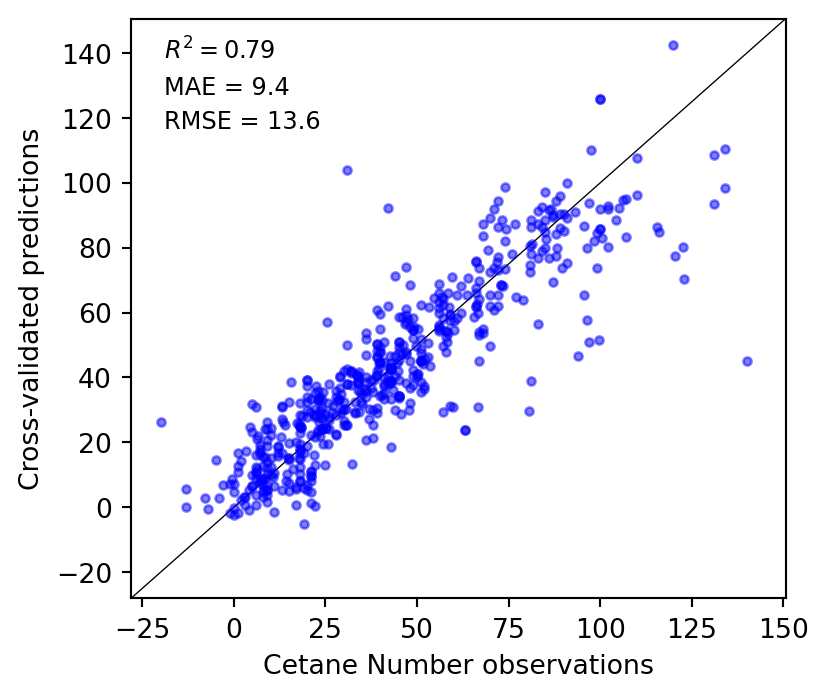

In [17]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Cetane Number observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/mol2vec/CN_mol2vec.svg') 

##  Melting Point (MP)

In [7]:
df = pd.read_csv("./data/data_MP.csv")
smiles = df.Smiles
Y = df.mpC
print(len(smiles))

27976


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


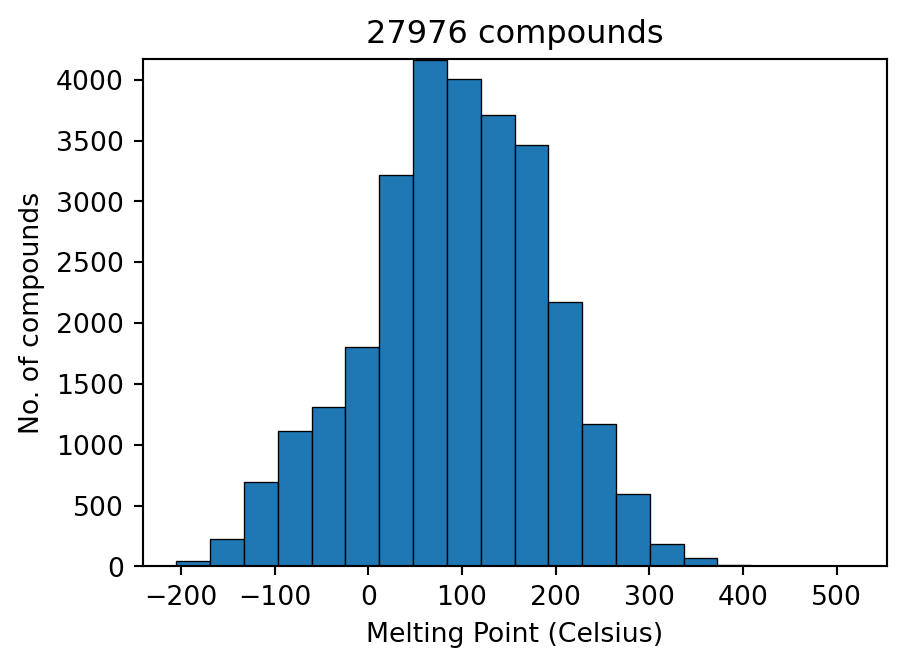

In [8]:
plot_histogram(Y, xlabel="Melting Point (Celsius)")

In [9]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='MP'].iloc[:,2:])
print(D.shape)

(27976, 300)


Define a smaller hyperparameter space as this is a large data set

In [10]:
param_grid = {
    'C': [100, 300, 500], 
    'epsilon': [3, 5, 10, 20],
    'kernel': ['rbf']
}

In [11]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 500, 'epsilon': 20, 'kernel': 'rbf'}
Partition 2/10
{'C': 500, 'epsilon': 20, 'kernel': 'rbf'}
Partition 3/10
{'C': 500, 'epsilon': 20, 'kernel': 'rbf'}
Partition 4/10
{'C': 500, 'epsilon': 20, 'kernel': 'rbf'}
Partition 5/10
{'C': 500, 'epsilon': 20, 'kernel': 'rbf'}
Partition 6/10
{'C': 500, 'epsilon': 20, 'kernel': 'rbf'}
Partition 7/10
{'C': 500, 'epsilon': 20, 'kernel': 'rbf'}
Partition 8/10
{'C': 500, 'epsilon': 10, 'kernel': 'rbf'}
Partition 9/10
{'C': 500, 'epsilon': 20, 'kernel': 'rbf'}
Partition 10/10
{'C': 500, 'epsilon': 20, 'kernel': 'rbf'}
CPU times: user 14h 42min 55s, sys: 1d 11h 23min 18s, total: 2d 2h 6min 13s
Wall time: 4h 9min 43s


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


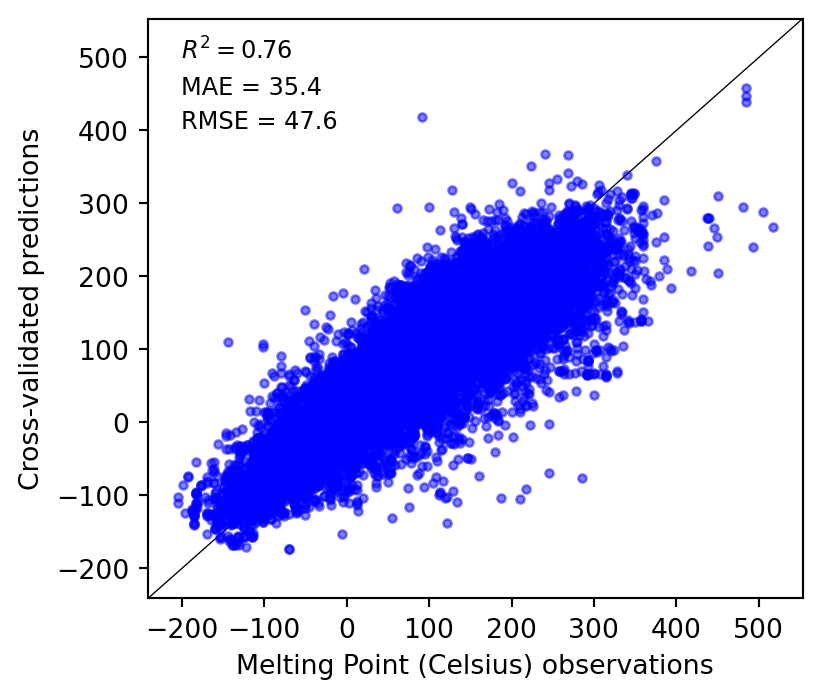

In [12]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Melting Point (Celsius) observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/mol2vec/MP_mol2vec.svg') 

## Flash Point (FP)

In [18]:
df = pd.read_csv("./data/data_FP.csv")
smiles = df.Smiles
Y = df.FP
print(len(smiles))

631


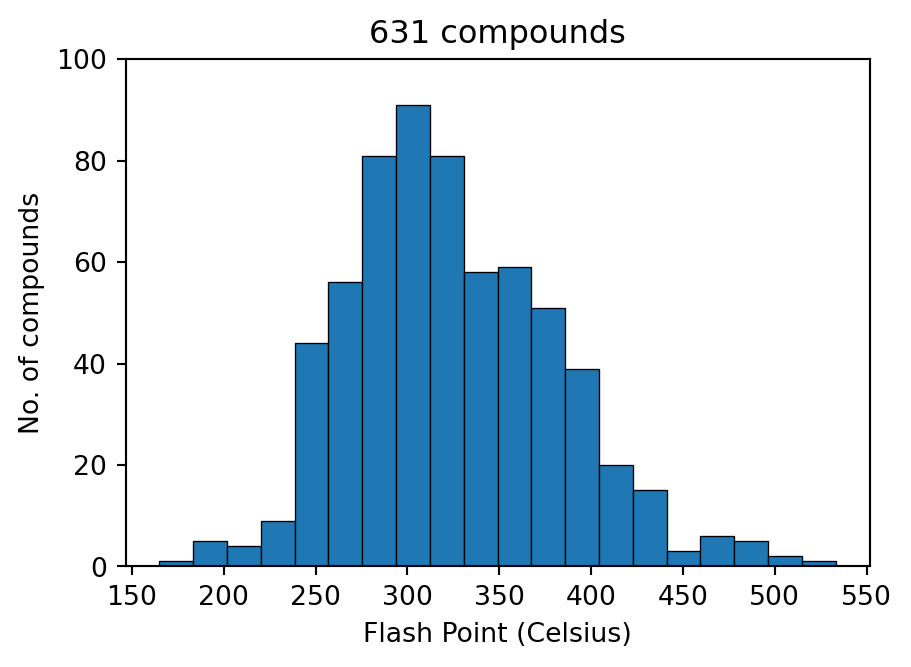

In [19]:
plot_histogram(Y, xlabel="Flash Point (Celsius)")

In [20]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='FP'].iloc[:,2:])
print(D.shape)

(631, 300)


In [21]:
param_grid = {
    'C': [1, 5, 7, 10, 30, 50, 100, 300, 500], 
    'epsilon': [0.1, 0.3, 1, 3, 5, 10, 20],
    'kernel': ['rbf']
}

In [22]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 300, 'epsilon': 20, 'kernel': 'rbf'}
Partition 2/10
{'C': 300, 'epsilon': 20, 'kernel': 'rbf'}
Partition 3/10
{'C': 300, 'epsilon': 20, 'kernel': 'rbf'}
Partition 4/10
{'C': 300, 'epsilon': 20, 'kernel': 'rbf'}
Partition 5/10
{'C': 300, 'epsilon': 20, 'kernel': 'rbf'}
Partition 6/10
{'C': 300, 'epsilon': 20, 'kernel': 'rbf'}
Partition 7/10
{'C': 500, 'epsilon': 10, 'kernel': 'rbf'}
Partition 8/10
{'C': 500, 'epsilon': 10, 'kernel': 'rbf'}
Partition 9/10
{'C': 300, 'epsilon': 20, 'kernel': 'rbf'}
Partition 10/10
{'C': 300, 'epsilon': 20, 'kernel': 'rbf'}
CPU times: user 4min 36s, sys: 243 ms, total: 4min 36s
Wall time: 4min 36s


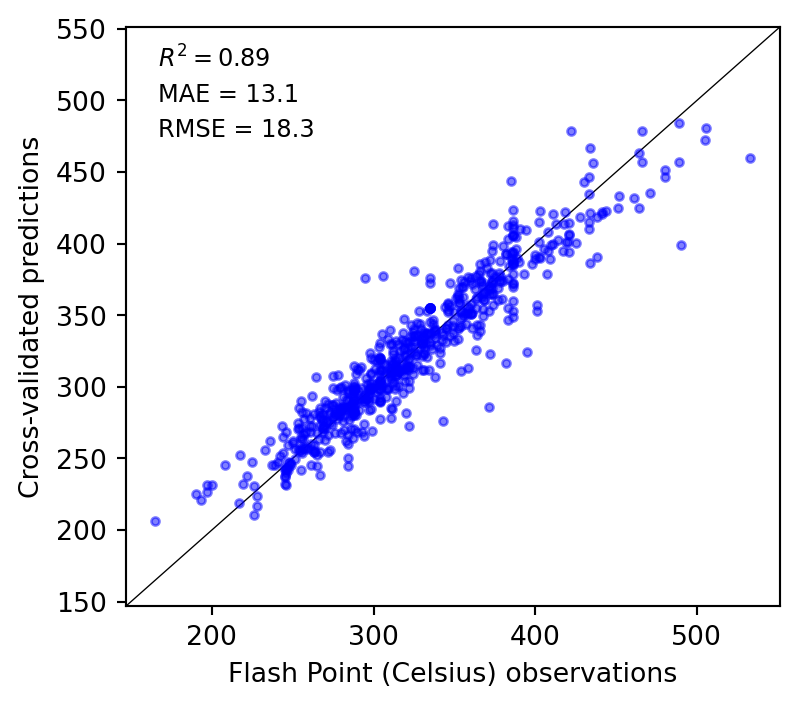

In [23]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Flash Point (Celsius) observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/mol2vec/FP_mol2vec.svg') 

## Histamine receptor pKi

In [24]:
df = pd.read_csv("./data/data_H1.csv")
Y = df.pKi
smiles = df.Smiles
print(len(smiles))

1214


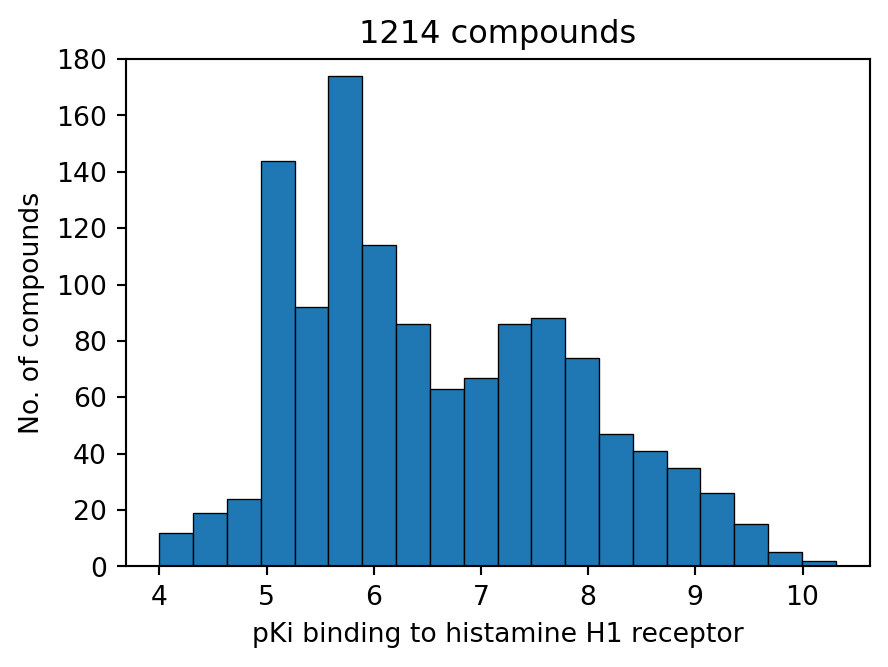

In [25]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

In [26]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='H1'].iloc[:,2:])
print(D.shape)

(1214, 300)


In [27]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 30, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 2/10
{'C': 10, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 3/10
{'C': 10, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 4/10
{'C': 30, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 5/10
{'C': 30, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 6/10
{'C': 100, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 7/10
{'C': 50, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 8/10
{'C': 30, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 9/10
{'C': 100, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 10/10
{'C': 30, 'epsilon': 0.3, 'kernel': 'rbf'}
CPU times: user 7min 16s, sys: 2min 50s, total: 10min 7s
Wall time: 6min 16s


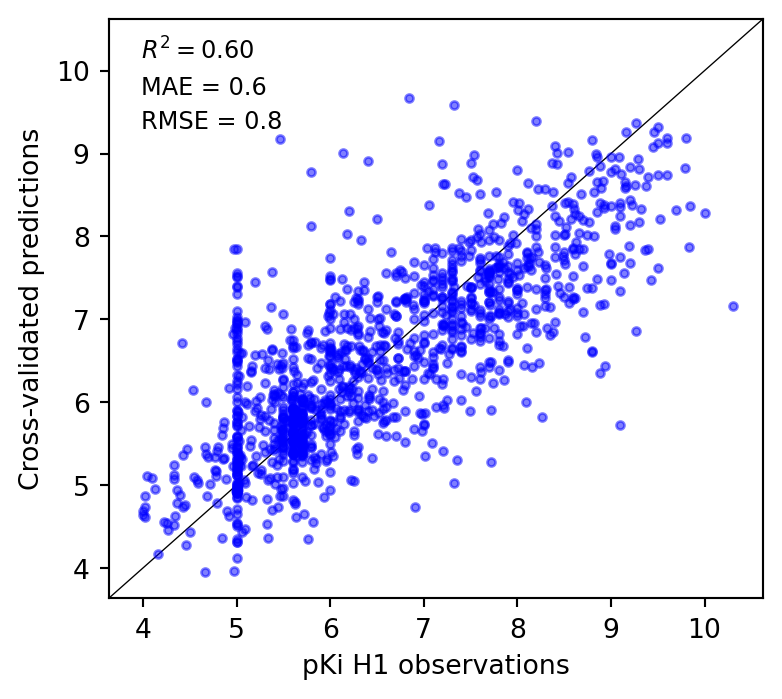

In [28]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="pKi H1 observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/mol2vec/H1_mol2vec.svg') 

## Muscarinic receptor pKi

In [29]:
df = pd.read_csv("./data/data_M2.csv")
Y = df.pKi
smiles = df.Smiles
print(len(smiles))

1145


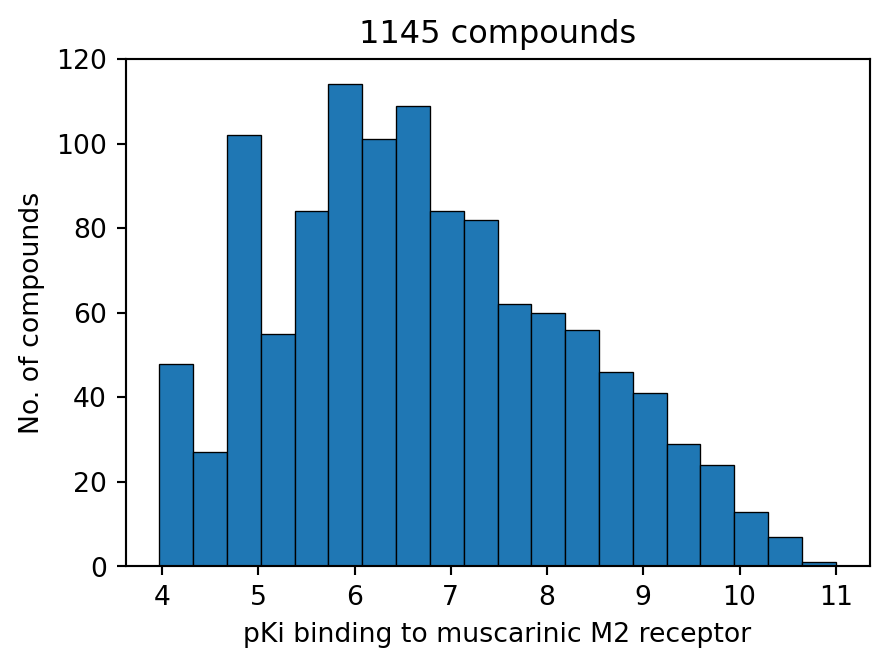

In [30]:
plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [31]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='M2'].iloc[:,2:])
print(D.shape)

(1145, 300)


In [32]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Train the SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 30, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 2/10
{'C': 30, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 3/10
{'C': 50, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 4/10
{'C': 100, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 5/10
{'C': 100, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 6/10
{'C': 30, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 7/10
{'C': 30, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 8/10
{'C': 30, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 9/10
{'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 10/10
{'C': 30, 'epsilon': 0.3, 'kernel': 'rbf'}
CPU times: user 6min 56s, sys: 2min 45s, total: 9min 42s
Wall time: 5min 57s


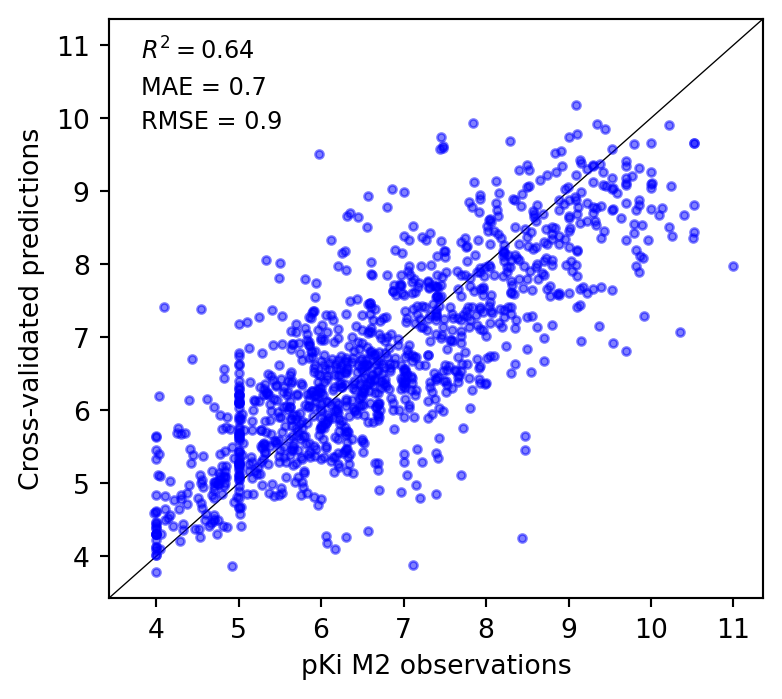

In [33]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="pKi M2 observations", 
            ylabel="Cross-validated predictions",
            savetitle='./results/mol2vec/M2_mol2vec.svg') 